In [287]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.metrics import CategoricalAccuracy, TopKCategoricalAccuracy, Precision, Recall
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.utils import to_categorical

from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

========

In [212]:
gdrive_path_prefix = ''

In [213]:
data = pd.concat([pd.read_csv(f'{gdrive_path_prefix}dataset/test_set.csv'), 
                  pd.read_csv(f'{gdrive_path_prefix}dataset/val_set.csv'), 
                  pd.read_csv(f'{gdrive_path_prefix}dataset/train_set_a.csv'), 
                  pd.read_csv(f'{gdrive_path_prefix}dataset/train_set_b.csv'), 
                  pd.read_csv(f'{gdrive_path_prefix}dataset/train_set_c.csv')], 
                 ignore_index=True, axis=0)

In [214]:
data.shape

(35887, 3)

In [215]:
data.head(2)

,emotion,pixels,Usage
0,0,254 254 254 254 254 249 255 160 2 58 53 70 77 ...,PublicTest
1,1,156 184 198 202 204 207 210 212 213 214 215 21...,PublicTest


In [216]:
data['pixels'][0] # pixels for each image is a string with val 0 - 255

'254 254 254 254 254 249 255 160 2 58 53 70 77 76 75 78 68 18 32 29 0 54 73 75 72 68 75 77 76 76 75 80 51 36 47 40 44 42 37 48 40 64 54 54 86 16 0 161 254 254 254 254 254 248 255 120 2 38 50 47 76 76 83 63 51 142 174 159 88 59 48 67 37 61 46 77 77 75 74 85 19 54 81 73 50 49 53 72 45 41 66 53 70 17 0 122 254 254 254 254 253 253 250 61 17 52 34 34 76 79 68 50 129 235 214 219 226 215 183 116 127 218 93 43 79 80 74 79 57 40 73 30 77 64 49 83 65 38 70 57 72 26 0 114 254 254 254 254 252 255 231 53 17 61 8 2 76 61 21 125 226 207 208 209 206 213 217 226 224 218 214 96 36 67 79 78 51 37 76 7 71 37 51 82 56 59 84 79 82 59 2 74 254 254 254 254 252 255 223 47 16 83 59 54 77 37 127 226 208 211 210 211 212 210 209 207 206 207 216 216 80 24 80 76 64 54 66 3 68 22 58 54 40 83 61 64 65 52 2 96 254 254 254 254 250 255 185 19 25 62 77 80 48 83 228 208 210 213 212 210 211 212 213 213 211 213 208 215 216 88 47 86 69 82 45 18 80 36 38 2 34 53 39 41 40 48 2 124 254 254 254 254 250 255 173 11 30 45 74 75 51 1

In [217]:
def pixstr_to_pixarr(x):
    return np.array(x.split(' ')).reshape(48, 48, 1).astype('float32')

data['pixels'] = data['pixels'].apply(pixstr_to_pixarr)

In [218]:
data['pixels'][0].shape # formatted to shape 48x48x1

(48, 48, 1)

## Plot selected Data

In [219]:
# the mapping of labes is as follows:
EMOTIONS = {
        0: 'anger', 
        1: 'disgust', 
        2: 'fear', 
        3: 'happiness', 
        4: 'sadness',
        5: 'surprise',
        6: 'neutral'
    }

label:  sadness


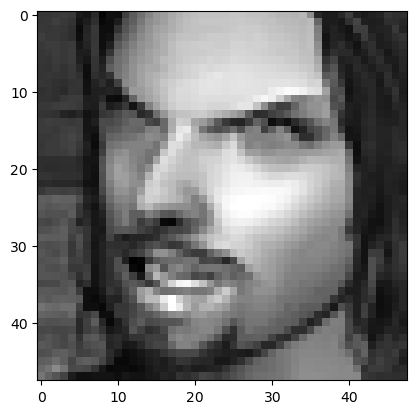

In [220]:
plt.imshow(data['pixels'][42].squeeze(), cmap='gray')
print('label: ', EMOTIONS[data['emotion'][42]])

label:  neutral


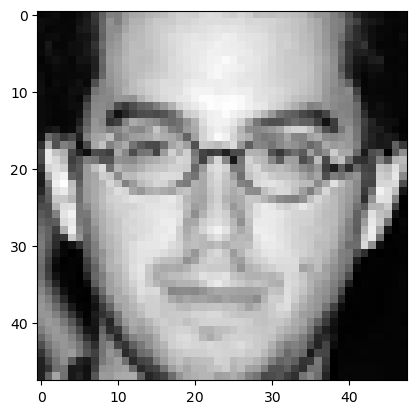

In [221]:
plt.imshow(data['pixels'][117].squeeze(), cmap='gray')
print('label: ', EMOTIONS[data['emotion'][117]])

<AxesSubplot: xlabel='emotion', ylabel='count'>

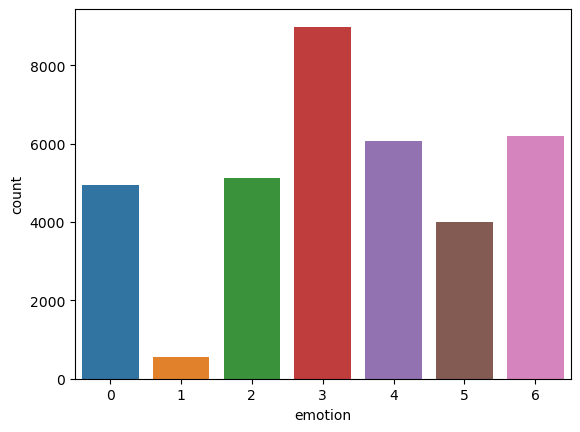

In [222]:
sns.countplot(x=data['emotion'], data=data)

### Preprocessing and Train Test Split

In [223]:
# before split to x and y - calculate class weights to combat imbalance 
cl = data['emotion'].value_counts().sort_index()
cl

0    4953
1     547
2    5121
3    8989
4    6077
5    4002
6    6198
Name: emotion, dtype: int64

In [224]:
class_weights = {}
for i, item in enumerate(cl):
  # see https://www.tensorflow.org/tutorials/structured_data/imbalanced_data for reference
  class_weights[i] = (1 / item) * (data.shape[0] / 2.0)

class_weights

{0: 3.622753886533414,
 1: 32.80347349177331,
 2: 3.5039054872095297,
 3: 1.9961619757481366,
 4: 2.952690472272503,
 5: 4.483633183408296,
 6: 2.8950467892868668}

In [225]:
# prepare X
X = data['pixels']
x_shape = X.shape[0]
X = np.stack(X, axis=0)
X = X.reshape(x_shape, 48, 48, 1) # make shape be consumable downstream

In [226]:
# prepare y
print(data['emotion'])
y = to_categorical(data['emotion'])

0        0
1        1
2        4
3        6
4        3
        ..
35882    2
35883    0
35884    4
35885    0
35886    4
Name: emotion, Length: 35887, dtype: int64


In [227]:
y.shape, X.shape

((35887, 7), (35887, 48, 48, 1))

In [228]:
# train test split
x_train, x_test_pre, y_train, y_test_pre = train_test_split(X, y, 
                                                            test_size=0.1, 
                                                            shuffle=True, 
                                                            stratify=y)

x_val, x_test, y_val, y_test = train_test_split(x_test_pre, y_test_pre, 
                                                test_size=0.5, shuffle=True, 
                                                stratify=y_test_pre)

In [229]:
x_train.shape, y_train.shape, x_val.shape, y_val.shape, x_test.shape, y_test.shape

((32298, 48, 48, 1),
 (32298, 7),
 (1794, 48, 48, 1),
 (1794, 7),
 (1795, 48, 48, 1),
 (1795, 7))

In [230]:
def image_normalizer(dataset):
    return dataset / 255.0

In [231]:
x_train_norm = image_normalizer(x_train)
x_val_norm = image_normalizer(x_val)
x_test_norm = image_normalizer(x_test)

## Set Up Image Generator with Augmentation

In [232]:
# Image Generator setup to feed to model fit
train_datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    fill_mode = "nearest",
    horizontal_flip=True
)

## Custom Model Definition

In [233]:
class CustomConv2D(Layer):
    def __init__(self, n_filters, kernel_size, n_strides, padding='valid'):
        super(CustomConv2D, self).__init__(name='custom_conv2d')
        
        self.conv = Conv2D(filters=n_filters,
                          kernel_size=kernel_size,
                          activation='relu',
                          strides=n_strides,
                          padding=padding)
        
        
        self.batch_norm = BatchNormalization()
        
    def call(self, x):
        x = self.conv(x)
        x = self.batch_norm(x)
        
        return x

In [234]:
class ResidualBlock(Layer):
    def __init__(self, n_channels, n_strides=1):
        super(ResidualBlock, self).__init__(name='res_block')
                 
        self.inputs_deviate = (n_strides != 1)
        
        self.custom_conv_1 = CustomConv2D(n_channels, 3, n_strides, padding='same')
        self.custom_conv_2 = CustomConv2D(n_channels, 3, 1, padding='same')
        self.activation = Activation('relu')
                 
        if self.inputs_deviate:
            self.custom_conv_3 = CustomConv2D(n_channels, 1, n_strides) # filter 1x1
            
        
    def call(self, input):
        x = self.custom_conv_1(input)
        x = self.custom_conv_2(x)
        
        if self.inputs_deviate:
            x_add = self.custom_conv_3(input)
            x_add = Add()([x, x_add])
        else:
            x_add = Add()([x, input])
        
        
        return self.activation(x_add)

In [235]:
# explicit implementation
class CustomResNet34(Model):
    def __init__(self, num_classes):
        super(CustomResNet34, self).__init__(name='resnet_34')
        
        # first section from paper
        self.conv_1 = CustomConv2D(64, 7, 2, padding='same')
        self.max_pool = MaxPool2D(3, 2)
        
        # ======= # paper: conv2_x section
        self.conv_2_1 = ResidualBlock(64)
        self.conv_2_2 = ResidualBlock(64)
        self.conv_2_3 = ResidualBlock(64)
        
        # ======= # paper: conv3_x section
        self.conv_3_1 = ResidualBlock(128, 2)
        self.conv_3_2 = ResidualBlock(128)
        self.conv_3_3 = ResidualBlock(128)
        self.conv_3_4 = ResidualBlock(128)
        
        # ======= # paper: conv4_x section
        self.conv_4_1 = ResidualBlock(256, 2)
        self.conv_4_2 = ResidualBlock(256)
        self.conv_4_3 = ResidualBlock(256)
        self.conv_4_4 = ResidualBlock(256)
        self.conv_4_5 = ResidualBlock(256)
        self.conv_4_6 = ResidualBlock(256)
        
        # ======= # paper: conv5_x section
        self.conv_5_1 = ResidualBlock(512, 2)
        self.conv_5_2 = ResidualBlock(512)
        self.conv_5_3 = ResidualBlock(512)
        
        self.global_pool = GlobalAveragePooling2D()
        self.fc_dense = Dense(num_classes, activation='softmax')
        
        
    
    def call(self, x):
        x = self.conv_1(x)
        x = self.max_pool(x)
        
        x = self.conv_2_1(x)
        x = self.conv_2_2(x)
        x = self.conv_2_3(x)
        
        x = self.conv_3_1(x)
        x = self.conv_3_2(x)
        x = self.conv_3_3(x)
        x = self.conv_3_4(x)
        
        x = self.conv_4_1(x)
        x = self.conv_4_2(x)
        x = self.conv_4_3(x) 
        x = self.conv_4_4(x)
        x = self.conv_4_5(x)
        x = self.conv_4_6(x)
        
        x = self.conv_5_1(x)
        x = self.conv_5_2(x)
        x = self.conv_5_3(x)
        
        x = self.global_pool(x)
        x = self.fc_dense(x)
        
        return x

## Create Custom ResNet Model

In [236]:
# create ResNet for 7 classes 
resnet_34 = CustomResNet34(7)

In [237]:
resnet_checkpoint_callback = ModelCheckpoint(f'{gdrive_path_prefix}best_weights_7_classes_ver1', 
                                             monitor='val_accuracy',
                                             mode='max',
                                             verbose=1,
                                             save_best_only=True)

In [243]:
metrics = [CategoricalAccuracy(name='accuracy'), 
           TopKCategoricalAccuracy(k=2, name='top_k_accuracy')]
loss_fn = CategoricalCrossentropy()

In [244]:
resnet_34.compile(optimizer=Adam(learning_rate=0.01), 
                  loss=loss_fn, 
                  metrics=metrics)

In [245]:
resnet_34.build(input_shape=(1, 48, 48, 1))
resnet_34.summary()

Model: "resnet_34"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 custom_conv2d (CustomConv2D  multiple                 3456      
 )                                                               
                                                                 
 max_pooling2d_20 (MaxPoolin  multiple                 0         
 g2D)                                                            
                                                                 
 res_block (ResidualBlock)   multiple                  74368     
                                                                 
 res_block (ResidualBlock)   multiple                  74368     
                                                                 
 res_block (ResidualBlock)   multiple                  74368     
                                                                 
 res_block (ResidualBlock)   multiple                  23

## Train Model

In [246]:
def plot_model_performance(h, metric, title):
    print(h[metric])
    plt.plot(h[metric])
    plt.plot(h[f'val_{metric}'])
    plt.title(f'Model {metric}')
    plt.ylabel(metric)
    plt.xlabel('epoch')
    plt.legend([f'train_{metric}', f'val_{metric}'])
    plt.title(title)
    plt.savefig(f'{gdrive_path_prefix}figures/{title}.png')
    plt.show()

In [271]:
from sklearn.utils import class_weight
# fit first without class weigths
history = resnet_34.fit(train_datagen.flow(x_train_norm, y_train, batch_size=128), epochs=3, 
                       validation_data=(x_val_norm, y_val), verbose=1, callbacks=[resnet_checkpoint_callback])

Epoch 1/3
253/253 [==============================] - ETA: 0s - loss: 1.0145 - accuracy: 0.6195 - top_k_accuracy: 0.8073
Epoch 1: val_accuracy did not improve from 0.56689
253/253 [==============================] - 1063s 4s/step - loss: 1.0145 - accuracy: 0.6195 - top_k_accuracy: 0.8073 - val_loss: 1.1871 - val_accuracy: 0.5379 - val_top_k_accuracy: 0.7475
Epoch 2/3
253/253 [==============================] - ETA: 0s - loss: 0.9945 - accuracy: 0.6257 - top_k_accuracy: 0.8090
Epoch 2: val_accuracy did not improve from 0.56689
253/253 [==============================] - 1081s 4s/step - loss: 0.9945 - accuracy: 0.6257 - top_k_accuracy: 0.8090 - val_loss: 1.3313 - val_accuracy: 0.4961 - val_top_k_accuracy: 0.7007
Epoch 3/3
253/253 [==============================] - ETA: 0s - loss: 0.9897 - accuracy: 0.6291 - top_k_accuracy: 0.8126
Epoch 3: val_accuracy improved from 0.56689 to 0.60758, saving model to best_weights_7_classes_ver1


INFO:tensorflow:Assets written to: best_weights_7_classes_ver1/assets


INFO:tensorflow:Assets written to: best_weights_7_classes_ver1/assets


253/253 [==============================] - 1047s 4s/step - loss: 0.9897 - accuracy: 0.6291 - top_k_accuracy: 0.8126 - val_loss: 1.0465 - val_accuracy: 0.6076 - val_top_k_accuracy: 0.7837


In [248]:
history

In [275]:
history.history

{'loss': [1.0145044326782227, 0.9945206642150879, 0.989699125289917],
 'accuracy': [0.6195120215415955, 0.6256734132766724, 0.6291411519050598],
 'top_k_accuracy': [0.8072636127471924,
  0.8089974522590637,
  0.8126199841499329],
 'val_loss': [1.1871459484100342, 1.33127760887146, 1.0465350151062012],
 'val_accuracy': [0.5379041433334351, 0.4960981011390686, 0.607580840587616],
 'val_top_k_accuracy': [0.7474916577339172,
  0.7006688714027405,
  0.7837235331535339]}

In [207]:
resnet34.evaluate(x_val_norm, y_val)

57/57 [==============================] - 4s 67ms/step - loss: 1.9041 - accuracy: 0.2720 - top_k_accuracy: 0.4476


[1.9040837287902832, 0.27201783657073975, 0.44760313630104065]

In [210]:
y_val.shape

(1794, 7)

In [276]:
# make sure that model is using best weights; not sure if I need to do this explicitly...
resnet_34.load_weights(f'{gdrive_path_prefix}best_weights_7_classes_ver1')
# Save the model to a JSON file - need to do it like this because I use subclassing method
tf.keras.models.save_model(resnet_34, f'{gdrive_path_prefix}custom_model_resnet34_7_classes_ver1', save_format='json')

2023-02-23 20:27:31.709218: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open best_weights_7_classes_ver1: FAILED_PRECONDITION: best_weights_7_classes_ver1; Is a directory: perhaps your file is in a different file format and you need to use a different restore operator?


INFO:tensorflow:Assets written to: custom_model_resnet34_7_classes_ver1/assets


INFO:tensorflow:Assets written to: custom_model_resnet34_7_classes_ver1/assets


[1.0145044326782227, 0.9945206642150879, 0.989699125289917]


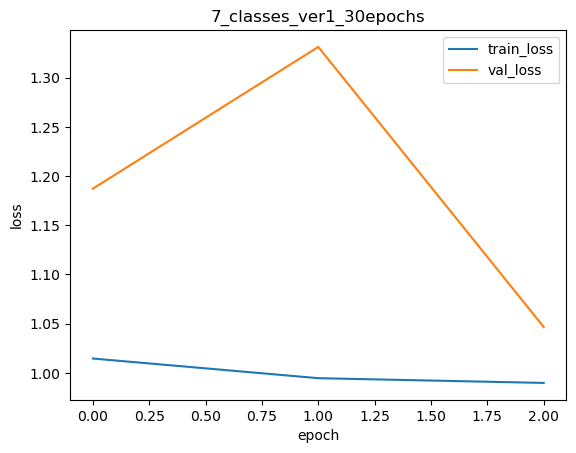

In [273]:
plot_model_performance(history.history, 'loss', '7_classes_ver1_30epochs')

[0.6195120215415955, 0.6256734132766724, 0.6291411519050598]


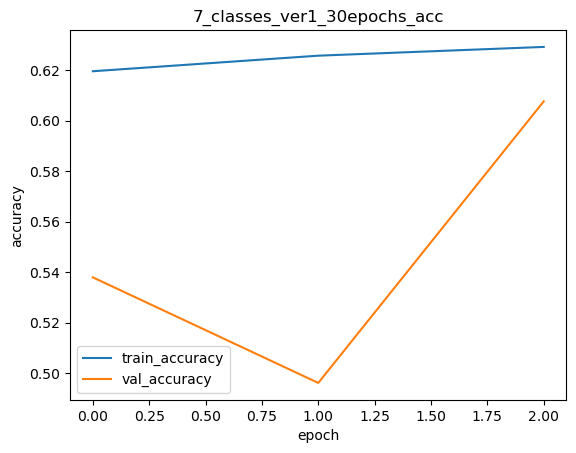

In [274]:
plot_model_performance(history.history, 'accuracy', '7_classes_ver1_30epochs_acc')

In [253]:
loaded_model_test = tf.keras.models.load_model(f'{gdrive_path_prefix}custom_model_resnet34_7_classes_ver1', compile=False)

In [255]:
selected_img = np.array([x_test_norm[0]])
pred_test = loaded_model_test.predict(selected_img)

1/1 [==============================] - 0s 405ms/step


In [256]:
np.argmax(pred_test)

3

In [257]:
np.argmax(y_test[0])

5

In [266]:
tf.__version__

'2.11.0'

### Predict

In [289]:
def show_confusion_matrix(y_pred, y_test, classes, title):
    cm = confusion_matrix(y_test, y_pred, labels=classes)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
    disp.plot(colorbar=False)
    disp.ax_.set_title(title)
    plt.show()

In [280]:
resnet34.evaluate(x_test_norm, y_test)

57/57 [==============================] - 4s 68ms/step - loss: 2.0376 - accuracy: 0.2507 - top_k_accuracy: 0.4451


[2.0375568866729736, 0.2506963908672333, 0.4451253414154053]

In [303]:
y_pred_test = resnet34.predict(x_test_norm)

57/57 [==============================] - 4s 68ms/step


In [304]:
y_pred_test

array([[0.1727513 , 0.0088799 , 0.13480715, ..., 0.15207459, 0.06070361,
        0.2410345 ],
       [0.20825085, 0.00170712, 0.15249433, ..., 0.21061753, 0.04341547,
        0.24171665],
       [0.17112279, 0.01069819, 0.15793912, ..., 0.14180124, 0.08599586,
        0.22493449],
       ...,
       [0.12394047, 0.02082751, 0.15127677, ..., 0.08969972, 0.15503658,
        0.20635027],
       [0.14547248, 0.01493651, 0.15746707, ..., 0.11532101, 0.11650476,
        0.21551666],
       [0.17111205, 0.00920783, 0.13450512, ..., 0.14993902, 0.0616753 ,
        0.23930049]], dtype=float32)

In [305]:
y_pred_test = [ np.argmax(x) for x in y_pred_test]
max(y_pred_test)

6

In [306]:
y_test_post = [ np.argmax(x) for x in y_test]

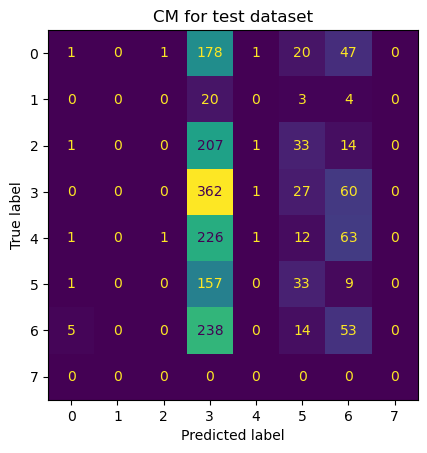

In [307]:
show_confusion_matrix(y_pred_test, y_test_post, [0, 1, 2, 3, 4, 5, 6, 7], 'CM for test dataset')